In [3]:
import numpy as np
import glob
import os
from opac_mixer.read import ReadOpacChubb
from opac_mixer.emulator import Emulator

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, STATUS_FAIL

2023-05-02 11:27:33.952020: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
R_10='10'
R_S1='S1'
base = f'{os.environ["pRT_input_data_path"]}/opacities/lines/corr_k'
files_10 = glob.glob(os.path.join(base,f'*_R_{R_10}/*.h5'))
files_S1 = glob.glob(os.path.join(base,f'*_R_{R_S1}/*.h5'))
opac_10 = ReadOpacChubb(files_10)
opac_S1 = ReadOpacChubb(files_S1)

batchsize = int(4e4)

load = False
load_model = False

In [5]:
em = Emulator([opac_10, opac_S1])

In [8]:
em.setup_sampling_grid(approx_batchsize=batchsize)
if not load:
    em.setup_mix(do_parallel=False)
else:
    em.load_data()
em.setup_scaling()

100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 12.61it/s]


In [9]:
deepset_params = {
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'hidden_units': hp.quniform('hidden_units', 8, 32, 2),
}
# Note: We may not be able to use early stopping, since results can be vary bad and that would break the fmin function

para = dict()
para['reg_params'] = deepset_params
para['reg_params']['verbose'] = False
para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(np.log(y), np.log(pred)))

In [10]:
class HPOpt(object):
    """
    Following this example:
    https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e
    """

    def __init__(self, emulator):
        self.emulator = emulator

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def deepset_reg(self, para):
        print(f'testing {para["reg_params"]}')
        para['reg_params']['hidden_units'] = int(para['reg_params']['hidden_units'])
        self.emulator.setup_model(**para['reg_params'])
        self.emulator.fit()
        pred = self.emulator.predict(self.emulator.X_test)
        loss = para['loss_func'](self.emulator.y_test, pred)
        print(loss)
        return {'loss': loss, 'status': STATUS_OK}

In [11]:
trials = Trials()

In [24]:
obj = HPOpt(em)

opt = obj.process(fn_name='deepset_reg', space=para, trials=trials, algo=tpe.suggest, max_evals=100)

testing {'hidden_units': 22.0, 'learning_rate': 0.009639427937547154, 'verbose': False}
0.8498246682000619                                                              
testing {'hidden_units': 28.0, 'learning_rate': 0.0007222199018827587, 'verbose': False}
0.6584006373828777                                                              
testing {'hidden_units': 16.0, 'learning_rate': 0.00042633055604179577, 'verbose': False}
0.5539265943469254                                                              
testing {'hidden_units': 32.0, 'learning_rate': 0.001360822606344268, 'verbose': False}
0.5127579313690871                                                              
testing {'hidden_units': 14.0, 'learning_rate': 0.0009791716540062023, 'verbose': False}
0.5681199037225347                                                              
testing {'hidden_units': 30.0, 'learning_rate': 0.004849545424759847, 'verbose': False}
0.6095323677716094                                             

In [25]:
trials.best_trial

{'state': 2,
 'tid': 65,
 'spec': None,
 'result': {'loss': 0.4895793657410836, 'status': 'ok'},
 'misc': {'tid': 65,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'hidden_units': [65], 'learning_rate': [65]},
  'vals': {'hidden_units': [32.0], 'learning_rate': [0.0007383167277272579]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2023, 5, 2, 10, 52, 9, 245000),
 'refresh_time': datetime.datetime(2023, 5, 2, 10, 53, 59, 519000)}

(array([10., 13., 18.,  8.,  2.,  7.,  4.,  6.,  8.,  8.,  3.,  6.,  0.,
         2.,  1.,  1.,  0.,  0.,  0.,  2.]),
 array([0.48957937, 0.51531799, 0.54105661, 0.56679524, 0.59253386,
        0.61827249, 0.64401111, 0.66974974, 0.69548836, 0.72122699,
        0.74696561, 0.77270423, 0.79844286, 0.82418148, 0.84992011,
        0.87565873, 0.90139736, 0.92713598, 0.9528746 , 0.97861323,
        1.00435185]),
 <BarContainer object of 20 artists>)

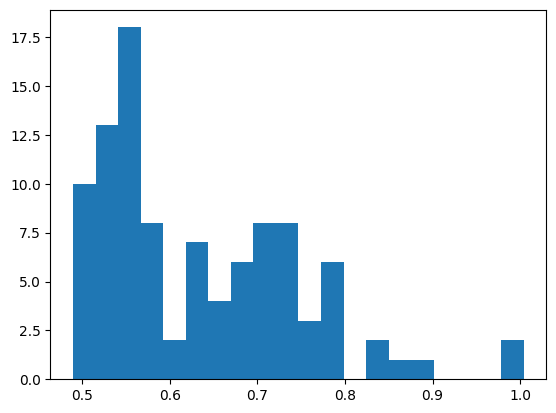

In [26]:
losses = np.asarray(trials.losses(), dtype=np.float_)
hist_cts, hist_edges = np.histogram(losses[np.isfinite(losses)])
plt.hist(losses[np.isfinite(losses)], bins=20)

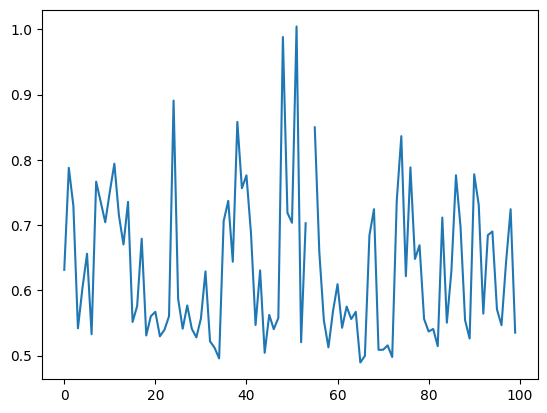

In [28]:
plt.plot(trials.losses())

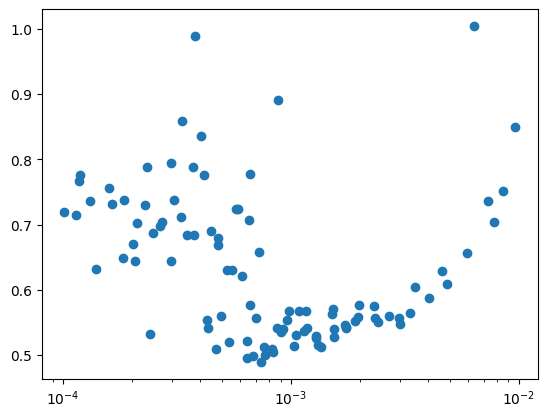

In [30]:
plt.scatter(trials.vals['learning_rate'], trials.losses(), )
plt.xscale('log')
plt.show()

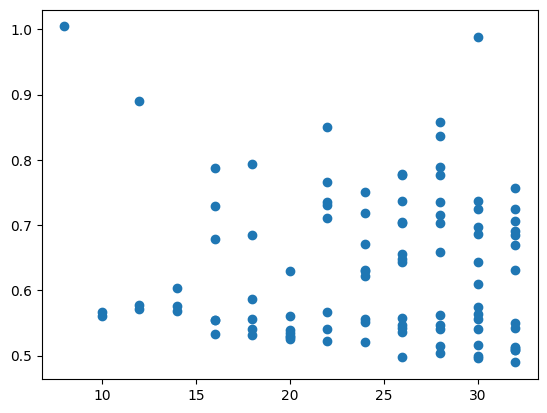

In [31]:
plt.scatter(trials.vals['hidden_units'], trials.losses(), )
plt.show()

In [ ]:
import pickle

In [ ]:
with open('data/hyperopt.pickle', 'wb') as f:
    pickle.dump(trials, f)